### Импорт библиотек и загрузка данных




In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
import time
import time as time_module 
import warnings
# Игнорировать все предупреждения
warnings.simplefilter("ignore")

# Загрузка данных для регрессии
data_regression = pd.read_csv("/Users/olegsuhov/Downloads/gen_regression.csv", index_col=0)
X_regression = pd.DataFrame(data_regression['x'])
y_regression = data_regression['y']

# Загрузка данных для классификации
data_classification = pd.read_csv("/Users/olegsuhov/Downloads/gen_classification.csv", index_col=0)
y_classification = data_classification['y']
X_classification = data_classification.drop(columns=["y"])

# Загрузка данных о ценах на дома
data_kc_prices = pd.read_csv("/Users/olegsuhov/Downloads/kc_house_data.csv")
y_kc_prices = data_kc_prices['price']
X_kc_prices = data_kc_prices.drop(columns=["id", "date", "price"])


### Полиномиальная регрессия




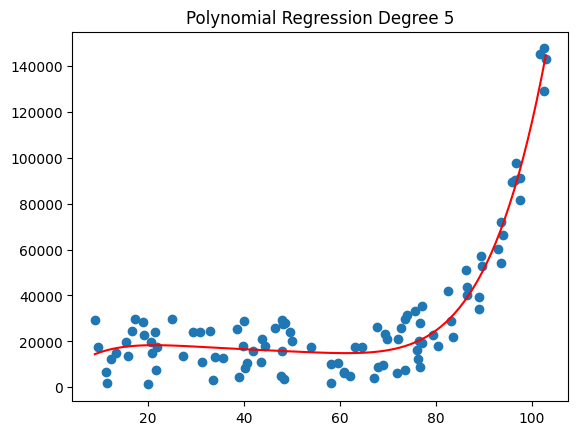

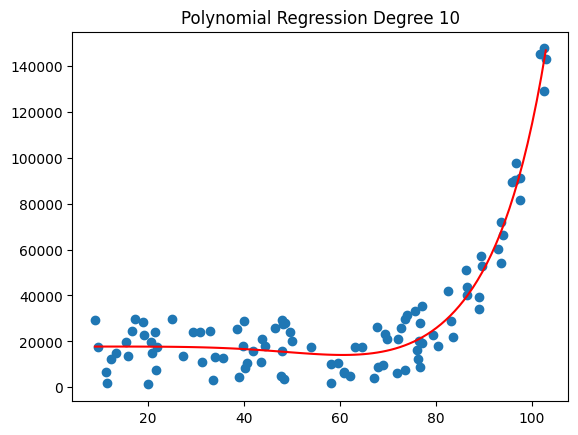

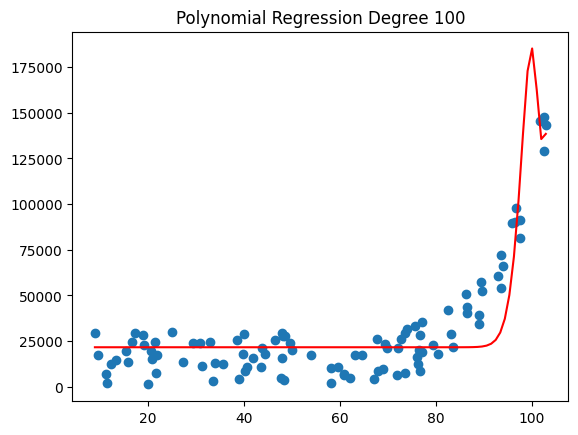

         Time       R^2
5    0.001507  0.921748
10   0.000328  0.922247
100  0.003176  0.792462


In [5]:
def train_model(X, y, degree):
    transformation = PolynomialFeatures(degree=degree)
    X_transformed = transformation.fit_transform(X)

    start_time = time_module.time()
    poly_model = LinearRegression().fit(X_transformed, y)
    train_duration = time_module.time() - start_time

    xx = pd.DataFrame(np.linspace(X['x'].min(), X['x'].max(), 100), columns=['x'])
    yy_pred = poly_model.predict(transformation.transform(xx))

    plt.scatter(X['x'], y)
    plt.plot(xx, yy_pred, c='r')
    plt.title(f'Polynomial Regression Degree {degree}')
    plt.show()

    r2 = poly_model.score(X_transformed, y)
    return train_duration, r2

degrees = [5, 10, 100]
results_regression = pd.DataFrame(index=degrees, columns=['Time', 'R^2'])

for degree in degrees:
    train_duration, r2 = train_model(X_regression, y_regression, degree)
    results_regression.loc[degree] = [train_duration, r2]

print(results_regression)


### Полиномиальная классификация




In [15]:
def poly_classifier(X, y, degree, get_params=False, show=True):
    transformation = PolynomialFeatures(degree=degree, include_bias=False)
    X_transformed = transformation.fit_transform(X)

    start_time = time_module.time()
    logistic_model = LogisticRegression(max_iter=1000).fit(X_transformed, y)
    train_duration = time_module.time() - start_time
    score = logistic_model.score(X_transformed, y)

    if show:
        xx, yy = np.meshgrid(np.arange(X.min()[0], X.max()[0] + 0.1, 0.01),
                             np.arange(X.min()[1], X.max()[1] + 0.1, 0.01))
        XX = np.array(list(zip(xx.ravel(), yy.ravel()))).reshape((-1, 2))
        Z = logistic_model.predict(transformation.transform(XX)).reshape(xx.shape)

        plt.contourf(xx, yy, Z, alpha=0.4)
        plt.scatter(X.iloc[:, 0][y == 0], X.iloc[:, 1][y == 0], marker="o", c='r', s=100)
        plt.scatter(X.iloc[:, 0][y == 1], X.iloc[:, 1][y == 1], marker="x", c='b', s=100)
        plt.title(f'Polynomial Classification Degree {degree}')
        plt.show()

    if get_params:
        return [train_duration, score]

degrees_classification = [5, 10, 100]
results_classification = pd.DataFrame(index=degrees_classification, columns=['Time', 'Score'])

for degree in degrees_classification:
    train_duration, score = poly_classifier(X_classification, y_classification, degree, get_params=True, show=False)
    results_classification.loc[degree] = [train_duration, score]

print(results_classification)



         Time  Score
5    0.007469  0.916
10   0.019137  0.924
100  0.076745    0.5


### Полиномиальная регрессия на данных о ценах на дома




In [17]:
def kc_classifier(X, y, degree, get_params=False, show=True):
    transformation = PolynomialFeatures(degree=degree)
    X_transformed = transformation.fit_transform(X)

    start_time = time_module.time()
    poly_model = LinearRegression().fit(X_transformed, y)
    train_duration = time_module.time() - start_time
    score = poly_model.score(X_transformed, y)

    if show:
        y_pred = poly_model.predict(X_transformed)
        plt.scatter(y_pred, y)
        plt.plot(y_pred, y_pred, c='r')
        plt.title(f'Polynomial Regression Degree {degree} on House Prices')
        plt.show()

    if get_params:
        return [train_duration, score]

degrees_kc = [2, 3]
results_kc = pd.DataFrame(index=degrees_kc, columns=['Time', 'Score'])

for degree in degrees_kc:
    train_duration, score = kc_classifier(X_kc_prices, y_kc_prices, degree, get_params=True, show=False)
    results_kc.loc[degree] = [train_duration, score]

print(results_kc)



       Time     Score
2  0.132322   0.80845
3  2.083986  0.832602


### Таблица эффективности моделей

In [18]:
# Объединение результатов
results_summary = pd.DataFrame({
    'Task': ['Regression'] * len(results_regression) +
             ['Classification'] * len(results_classification) +
             ['House Prices'] * len(results_kc),
    'Degree': list(results_regression.index) + list(results_classification.index) + list(results_kc.index),
    'Time': list(results_regression['Time']) + list(results_classification['Time']) + list(results_kc['Time']),
    'Score': list(results_regression['R^2']) + list(results_classification['Score']) + list(results_kc['Score'])
})

print(results_summary)


             Task  Degree      Time     Score
0      Regression       5  0.001507  0.921748
1      Regression      10  0.000328  0.922247
2      Regression     100  0.003176  0.792462
3  Classification       5  0.007469  0.916000
4  Classification      10  0.019137  0.924000
5  Classification     100  0.076745  0.500000
6    House Prices       2  0.132322  0.808450
7    House Prices       3  2.083986  0.832602


### Коэффициенты линейной модели

          Feature  Coefficient
0        bedrooms   -35766.541
1       bathrooms    41144.279
2     sqft_living      110.443
3        sqft_lot        0.129
4          floors     6689.550
5      waterfront   582960.458
6            view    52870.942
7       condition    26385.649
8           grade    95890.445
9      sqft_above       70.785
10  sqft_basement       39.658
11       yr_built    -2620.223
12   yr_renovated       19.813
13        zipcode     -582.420
14            lat   602748.226
15           long  -214729.828
16  sqft_living15       21.681
17     sqft_lot15       -0.383


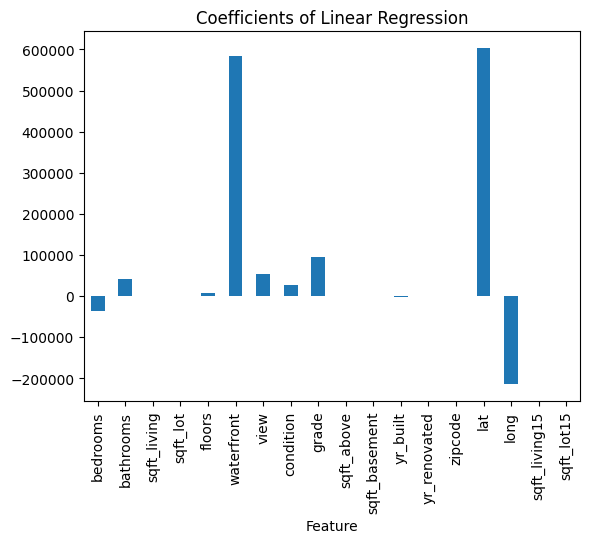

In [19]:
# Коэффициенты линейной модели для данных о ценах на дома
linear_model = LinearRegression().fit(X_kc_prices, y_kc_prices)
coefficients = pd.DataFrame({'Feature': X_kc_prices.columns, 'Coefficient': linear_model.coef_})
coefficients['Coefficient'] = coefficients['Coefficient'].round(3)

print(coefficients)
coefficients.plot(kind='bar', x='Feature', y='Coefficient', legend=False)
plt.title('Coefficients of Linear Regression')
plt.show()


### Интерпретация полиномиальной модели

          Feature  Coefficient
0               1         -0.0
1        bedrooms          0.0
2       bathrooms          0.0
3     sqft_living          0.0
4        sqft_lot          0.0
5          floors          0.0
6      waterfront         -0.0
7            view          0.0
8       condition         -0.0
9           grade          0.0
10     sqft_above          0.0
11  sqft_basement          0.0
12       yr_built          0.0
13   yr_renovated         -0.0
14        zipcode          0.0
15            lat          0.0
16           long          0.0
17  sqft_living15          0.0


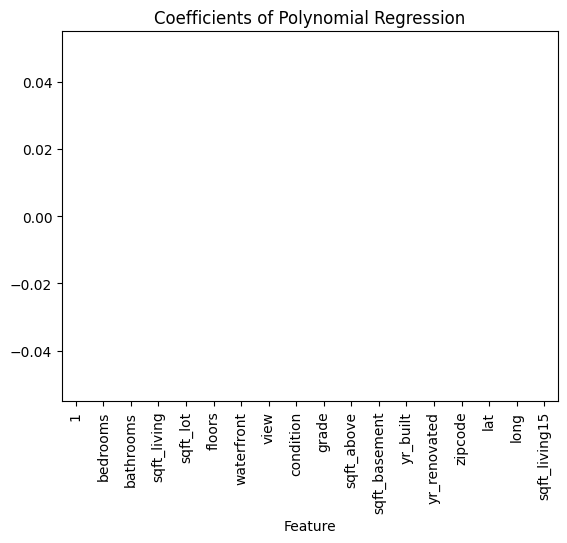

In [20]:
# Полиномиальная модель для данных о ценах на дома
transformation_kc = PolynomialFeatures(degree=3)
X_kc_transformed = transformation_kc.fit_transform(X_kc_prices)
poly_model_kc = LinearRegression().fit(X_kc_transformed, y_kc_prices)

# Коэффициенты полиномиальной модели
coef_poly = pd.DataFrame({'Feature': transformation_kc.get_feature_names_out(), 'Coefficient': poly_model_kc.coef_})
coef_poly = coef_poly.iloc[:18, :]  # Показать только основные коэффициенты
coef_poly['Coefficient'] = coef_poly['Coefficient'].round(3)

print(coef_poly)
coef_poly.plot(kind='bar', x='Feature', y='Coefficient', legend=False)
plt.title('Coefficients of Polynomial Regression')
plt.show()
